In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\juand\.cache\kagglehub\datasets\abdallahalidev\plantvillage-dataset\versions\3


# 🌽 Proyecto Final - Modelo de IA para el diagnostico temprano de enfermedades en maiz a partir de imagenes de hojas

# Autores:
Cesar Alejandro Soto Paipa - 2225612

Emersson Elian Lopez Pita - 2225507

Juan David Mena Gamboa - 2221886

# Dataset: PlantVilalage
https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset

##  Descripción del Proyecto

Este proyecto implementa un sistema completo de inteligencia artificial para la detección automática de enfermedades en hojas de maíz utilizando el dataset **PlantVillage**. Combina múltiples enfoques de Machine Learning, Deep Learning y análisis no supervisado para crear una solución robusta y validada.

##  Objetivos Principales

- **Análisis Exploratorio**: Comprender y visualizar el dataset PlantVillage
- **Machine Learning Tradicional**: Implementar modelos con features simples (mean/std RGB)
- **Deep Learning**: Desarrollar un MLP personalizado para clasificación
- **Validación No Supervisada**: Usar clustering para validar las features aprendidas
- **Comparativa Integral**: Evaluar diferentes enfoques de IA



##  Metodología Implementada

### **Fase 1: Análisis Exploratorio**
- Estructura y distribución del dataset
- Visualización de imágenes por clase
- Análisis de dimensiones y estadísticas

### **Fase 2: Aprendizaje Supervisado**
- **Modelos ML**: Decision Tree, Random Forest, SVM
- **Deep Learning**: Con un modelo MLP
- **Evaluación**: Accuracy, matrices de confusión, curvas de aprendizaje

### **Fase 3: Aprendizaje No Supervisado**
- **Extracción de Features**: Capas profundas del MLP
- **Reducción Dimensional**: PCA (10 componentes), t-SNE (visualización)
- **Clustering**: KMeans, DBSCAN, Agglomerative Clustering
- **Validación**: Método del codo, métricas ARI y Silhouette


##  Tecnologías y Librerías

- **Lenguaje**: Python 3.x
- **ML Tradicional**: Scikit-learn, Pandas, NumPy
- **Deep Learning**: TensorFlow/Keras
- **Visualización**: Matplotlib, Seaborn
- **Entorno**: Google Colab

##  Resultados Esperados

- Modelos de ML con accuracy competitiva (>85%)
- MLP capaz de generalizar en nuevas imágenes
- Validación de que las features aprendidas son biológicamente relevantes
- Coherencia entre métodos supervisados y no supervisados
- Sistema integral para detección temprana de enfermedades


** Proyecto desarrollado como trabajo final de Inteligencia Artificial**

In [ ]:
# =========================
# 0) CONFIG / MOUNT DRIVE /
# =========================
from google.colab import drive
drive.mount('/content/drive')

ROOT_DRIVE = "/content/drive/MyDrive/PlantVillage"
DATA_COLOR = os.path.join(ROOT_DRIVE, "color")
print("DATA_COLOR expected:", DATA_COLOR)


# 1) Descarga alternativa vía kagglehub (opcional)

In [ ]:
# 1b) Intento de descarga si no existe (opcional)
if not os.path.isdir(DATA_COLOR):
    print("No se encontró la carpeta en Drive. Intentando descarga con kagglehub (si está disponible)...")
    try:
        import kagglehub
        path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
        print("Path to dataset files:", path)
        # intentar localizar carpeta "color" dentro del dataset descargado
        possible = os.path.join(path, "color")
        if os.path.isdir(possible):
            # copiar o montar según sea necesario (simple aviso)
            print("Encontrada carpeta 'color' en:", possible)
            print("Si quieres, copia manualmente a Drive o ajusta DATA_COLOR a esta ruta.")
        else:
            print("No se encontró carpeta 'color' dentro del dataset descargado. Revisa manualmente.")
    except Exception as e:
        print("kagglehub no disponible o fallo en descarga:", e)
        print("Por favor asegúrate de subir la carpeta PlantVillage/color a Drive o instala kagglehub.")
else:
    print("Carpeta encontrada en Drive; continuamos.")


# 2) Librerias Usadas

In [ ]:
# =========================
# LIBRERÍAS UNIFICADAS
# =========================

# Configuración y manejo de datos
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

# Machine Learning tradicional
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.spatial.distance import cdist

# Deep Learning
import tensorflow as tf
import keras
from tensorflow.keras import Model, layers
from PIL import Image

# Configuración de estilo
sns.set(style="whitegrid")

# Reproducibilidad
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


# 3) Analisis Estructural del dataset

In [ ]:

print("=== ANÁLISIS ESTRUCTURAL - DATASET PLANTVILLAGE ===")

# ESTRUCTURA DE CARPETAS
print("\n ESTRUCTURA DE CARPETAS:")
print(f"Ruta del dataset: {DATA_COLOR}")

# Verificar que todas las carpetas existan
print("\n VERIFICACIÓN DE CARPETAS:")
for clase in clases_corn:
    folder = os.path.join(DATA_COLOR, clase)
    existe = " EXISTE" if os.path.exists(folder) else " NO EXISTE"
    print(f"  {existe} - {clase}")

# CONTEO DE IMÁGENES POR CLASE
print("\n CONTEO DE IMÁGENES POR CLASE:")
clases_stats = []
total_imagenes = 0

for clase in clases_corn:
    folder = os.path.join(DATA_COLOR, clase)
    if os.path.exists(folder):
        archivos = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        num_imagenes = len(archivos)
        clases_stats.append((clase, num_imagenes))
        total_imagenes += num_imagenes
        print(f"  {clase}: {num_imagenes} imágenes")

print(f"\n TOTAL DE IMÁGENES EN EL DATASET: {total_imagenes}")

df_resumen = pd.DataFrame(clases_stats, columns=['Clase', 'Número de Imágenes'])
df_resumen['Porcentaje'] = (df_resumen['Número de Imágenes'] / total_imagenes * 100).round(2)

# 4) Distrubucion

In [ ]:

print("\n=== VISUALIZACIÓN DE DISTRIBUCIÓN ===")

# GRÁFICO
plt.figure(figsize=(10, 6))
bars = plt.barh(df_resumen['Clase'], df_resumen['Número de Imágenes'],
                color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.xlabel('Número de Imágenes')
plt.title('Distribución de Imágenes por Clase - PlantVillage')
plt.grid(axis='x', alpha=0.3)

for bar, valor in zip(bars, df_resumen['Número de Imágenes']):
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
             f'{valor}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(df_resumen['Número de Imágenes'],
        labels=df_resumen['Clase'],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        shadow=True)
plt.title('Distribución Porcentual de Clases')
plt.show()

print("\n TABLA RESUMEN DEL DATASET:")
print("="*55)
print(f"{'CLASE':<50} {'IMÁGENES':<10} {'%':<6}")
print("="*55)
for _, row in df_resumen.iterrows():
    clase_corta = row['Clase'][:48] + "..." if len(row['Clase']) > 50 else row['Clase']
    print(f"{clase_corta:<50} {row['Número de Imágenes']:<10} {row['Porcentaje']:<6}")
print("="*55)
print(f"{'TOTAL':<50} {total_imagenes:<10} {'100%':<6}")

# 5) Muestra Visual de Imagenes

In [ ]:

print("\n=== MUESTRA VISUAL DE IMÁGENES ===")

def mostrar_ejemplos_por_clase(clase, num_ejemplos=3):
    """Ejemplos de imágenes para las clases"""
    print(f"\n MOSTRANDO EJEMPLOS: {clase}")

    folder = os.path.join(DATA_COLOR, clase)
    archivos = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    # Tomar muestra aleatoria
    muestra = np.random.choice(archivos, min(num_ejemplos, len(archivos)), replace=False)

    fig, axes = plt.subplots(1, num_ejemplos, figsize=(15, 4))

    for j, archivo in enumerate(muestra):
        img_path = os.path.join(folder, archivo)
        try:
            img = Image.open(img_path)
            if num_ejemplos > 1:
                axes[j].imshow(img)
                axes[j].set_title(f'Ejemplo {j+1}\n{archivo[:15]}...', fontsize=10)
                axes[j].axis('off')
            else:
                axes.imshow(img)
                axes.set_title(f'{clase}\n{archivo[:15]}...', fontsize=10)
                axes.axis('off')
        except Exception as e:
            if num_ejemplos > 1:
                axes[j].text(0.5, 0.5, f'Error\ncargando', ha='center', va='center')
                axes[j].axis('off')
            else:
                axes.text(0.5, 0.5, f'Error\ncargando', ha='center', va='center')
                axes.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar ejemplos para cada clase
for clase in clases_corn:
    mostrar_ejemplos_por_clase(clase, num_ejemplos=3)

# 6) Dimensiones de las imagenes

In [ ]:

print("\n=== ANÁLISIS DE DIMENSIONES DE IMÁGENES ===")

dimensiones = []
print(" Analizando dimensiones de muestra de imágenes...")

for clase in clases_corn:
    folder = os.path.join(DATA_COLOR, clase)
    archivos = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    muestra = np.random.choice(archivos, min(5, len(archivos)), replace=False)

    for archivo in muestra:
        img_path = os.path.join(folder, archivo)
        try:
            with Image.open(img_path) as img:
                ancho, alto = img.size
                dimensiones.append((clase, ancho, alto, archivo))
        except Exception as e:
            continue

df_dimensiones = pd.DataFrame(dimensiones, columns=['Clase', 'Ancho', 'Alto', 'Archivo'])

print("\n ESTADÍSTICAS DE DIMENSIONES:")
print("="*60)
stats = df_dimensiones.groupby('Clase').agg({
    'Ancho': ['min', 'max', 'mean'],
    'Alto': ['min', 'max', 'mean']
}).round(0)

print(stats)
print("="*60)



# Fase 2 del proyecto Aprendizaje Supervisado

# 7) Verificación de carpetas y detección de clases Corn


In [ ]:
#  Verificar que exista la ruta y detectar carpetas que empiezan con "Corn"
if not os.path.isdir(DATA_COLOR):
    raise FileNotFoundError(f"No se encontró la carpeta: {DATA_COLOR}. Por favor sube PlantVillage/color a tu Drive.")

clases_corn = [d for d in os.listdir(DATA_COLOR) if d.startswith("Corn")]
clases_corn = sorted(clases_corn)
print("Clases detectadas:", clases_corn)

if len(clases_corn) == 0:
    raise RuntimeError("No se detectaron carpetas que empiecen por 'Corn' en la ruta. Revisa la estructura.")


# 8)  Carga y extraccion de features (mean / std)


In [ ]:
# 4) Cargar imágenes, extraer mean/std
data = []

for label in clases_corn:
    folder = os.path.join(DATA_COLOR, label)
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    print(f"Cargando {label}: {len(files)} imágenes")
    for file in tqdm(files, desc=f"Cargando {label}"):
        try:
            img_path = os.path.join(folder, file)
            img = Image.open(img_path).convert("RGB").resize((64,64))
            arr = np.array(img)/255.0
            mean = arr.mean(axis=(0,1))
            std = arr.std(axis=(0,1))
            features = np.concatenate([mean,std])
            data.append([*features, label])
        except Exception as e:
            # no interrumpimos el proceso por una imagen corrupta
            continue

columns = ['mean_R','mean_G','mean_B','std_R','std_G','std_B','label']
df = pd.DataFrame(data, columns=columns)
df['label'] = df['label'].str.strip()

print("Tamaño del dataset:", df.shape)
print("\nCantidad de imágenes por clase:")
print(df['label'].value_counts())


Distribucion de las Clases

In [ ]:


print(df.describe().T)


# 9) Preparación para ML clásico: split train/test, scaling


In [ ]:
#  Split train/test y escalado
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=seed
)

scaler = StandardScaler() # Esto es para normalizar
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Tamaño train:", X_train.shape, " | Tamaño test:", X_test.shape)


# 10) Modelos ML: Decision Tree, Random Forest, SVM


In [ ]:
#  Entrenamiento de modelos
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=seed),
    "SVM": SVC(kernel='rbf', random_state=seed)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    results[name] = acc


In [ ]:
#  Comparación visual de accuracies
plt.figure(figsize=(7,4))
plt.bar(results.keys(), results.values(), color=['#5DADE2','#58D68D','#F5B041'])
plt.title("Comparación de Accuracy entre modelos")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i,(k,v) in enumerate(results.items()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.show()

print("Resultados resumen:")
for k,v in results.items():
    print(f"{k}: {v:.3f}")


# 11) Validación cruzada (KFold)


In [ ]:
#  KFold 5-fold en train
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
    print(f"{name} | Accuracy promedio (5-fold): {scores.mean():.3f} ± {scores.std():.3f}")


# 12) Matriz de confusión del mejor modelo


In [ ]:
# ) Matriz confusión para el mejor modelo
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title(f"Matriz de confusión - {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

print(f"Mejor modelo: {best_model_name}")


# 13) Curvas de aprendizaje — SVM, Decision Tree, Random Forest


In [ ]:
#  Curva de aprendizaje - SVM
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=seed)
train_sizes_svm, train_scores_svm, val_scores_svm = learning_curve(
    svm_classifier,
    X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy', n_jobs=-1
)
train_mean_svm = np.mean(train_scores_svm, axis=1)
val_mean_svm = np.mean(val_scores_svm, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes_svm, train_mean_svm, 'o-', label="Entrenamiento (SVM)")
plt.plot(train_sizes_svm, val_mean_svm, 'o-', label="Validación (SVM)")
plt.title("Curva de aprendizaje - SVM")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ) Curva de aprendizaje - Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=seed)
train_sizes_dt, train_scores_dt, val_scores_dt = learning_curve(
    dt_classifier,
    X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy', n_jobs=-1
)
train_mean_dt = np.mean(train_scores_dt, axis=1)
val_mean_dt = np.mean(val_scores_dt, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes_dt, train_mean_dt, 'o-', label="Entrenamiento (Decision Tree)")
plt.plot(train_sizes_dt, val_mean_dt, 'o-', label="Validación (Decision Tree)")
plt.title("Curva de aprendizaje - Decision Tree")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ) Curva de aprendizaje - Random Forest
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, random_state=seed),
    X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy', n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label="Entrenamiento")
plt.plot(train_sizes, val_mean, 'o-', label="Validación")
plt.title("Curva de aprendizaje - Random Forest")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## Verificación de Dimensiones de Imágenes

Esta función verifica si todas las imágenes en un directorio tienen las mismas dimensiones. Es útil para asegurar la consistencia del dataset antes de entrenar modelos de machine learning, especialmente cuando se requiere que todas las imágenes tengan el mismo tamaño (como 256x256 píxeles).


In [ ]:
def verificar_dimensiones_imagenes(directorio, dimensiones_esperadas=(256, 256)):
    """
    Verifica si todas las imágenes en un directorio tienen las mismas dimensiones.
    
    Args:
        directorio (str): Ruta al directorio que contiene las imágenes
        dimensiones_esperadas (tuple): Dimensiones esperadas (ancho, alto). Default: (256, 256)
    
    Returns:
        dict: Diccionario con información sobre la verificación
    """
    import os
    from PIL import Image
    
    # Obtener lista de archivos de imagen
    extensiones_validas = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.JPG', '.JPEG', '.PNG')
    archivos_imagen = [f for f in os.listdir(directorio) if f.endswith(extensiones_validas)]
    
    if not archivos_imagen:
        return {"error": "No se encontraron archivos de imagen en el directorio"}
    
    # Verificar cada imagen
    dimensiones_encontradas = set()
    imagenes_problematicas = []
    total_imagenes = len(archivos_imagen)
    
    for archivo in archivos_imagen:
        try:
            ruta_completa = os.path.join(directorio, archivo)
            with Image.open(ruta_completa) as img:
                dimensiones = img.size  # (ancho, alto)
                dimensiones_encontradas.add(dimensiones)
                
                if dimensiones != dimensiones_esperadas:
                    imagenes_problematicas.append({
                        'archivo': archivo,
                        'dimensiones': dimensiones,
                        'esperadas': dimensiones_esperadas
                    })
        except Exception as e:
            imagenes_problematicas.append({
                'archivo': archivo,
                'error': str(e)
            })
    
    # Resultados
    todas_iguales = len(dimensiones_encontradas) == 1
    dimensiones_correctas = todas_iguales and list(dimensiones_encontradas)[0] == dimensiones_esperadas
    
    return {
        'total_imagenes': total_imagenes,
        'dimensiones_esperadas': dimensiones_esperadas,
        'dimensiones_encontradas': list(dimensiones_encontradas),
        'todas_iguales': todas_iguales,
        'dimensiones_correctas': dimensiones_correctas,
        'imagenes_problematicas': imagenes_problematicas,
        'porcentaje_correcto': ((total_imagenes - len(imagenes_problematicas)) / total_imagenes) * 100
    }

# Ejemplo de uso
resultado = verificar_dimensiones_imagenes("plantvillage dataset/color/Potato___Early_blight")
print(f"Total de imágenes: {resultado['total_imagenes']}")
print(f"Dimensiones encontradas: {resultado['dimensiones_encontradas']}")
print(f"Todas tienen las mismas dimensiones: {resultado['todas_iguales']}")
print(f"Dimensiones correctas (256x256): {resultado['dimensiones_correctas']}")
print(f"Porcentaje correcto: {resultado['porcentaje_correcto']:.1f}%")

if resultado['imagenes_problematicas']:
    print(f"\nImágenes problemáticas: {len(resultado['imagenes_problematicas'])}")
    for img in resultado['imagenes_problematicas'][:5]:  # Mostrar solo las primeras 5
        print(f"  - {img['archivo']}: {img.get('dimensiones', 'Error al cargar')}")


Total de imágenes: 1000
Dimensiones encontradas: [(256, 256)]
Todas tienen las mismas dimensiones: True
Dimensiones correctas (256x256): True
Porcentaje correcto: 100.0%


## Estructura de una Imagen Digital

### Dimensiones de una Imagen (256, 256, 3)

Una imagen digital se representa como un **tensor de 3 dimensiones**:

1. **Primera dimensión (256)**: **Filas** - Altura de la imagen en píxeles
2. **Segunda dimensión (256)**: **Columnas** - Ancho de la imagen en píxeles  
3. **Tercera dimensión (3)**: **Canales de color** - RGB (Red, Green, Blue)

### ¿Qué es un canal de color?

Cada píxel de una imagen a color se compone de **3 valores**:
- **Canal Rojo (R)**: Intensidad del rojo (0-255)
- **Canal Verde (G)**: Intensidad del verde (0-255)
- **Canal Azul (B)**: Intensidad del azul (0-255)

### Estructura de la Matriz

```
Imagen[256, 256, 3] = [
  [píxel(0,0) = [R, G, B], píxel(0,1) = [R, G, B], ..., píxel(0,255) = [R, G, B]],
  [píxel(1,0) = [R, G, B], píxel(1,1) = [R, G, B], ..., píxel(1,255) = [R, G, B]],
  ...
  [píxel(255,0) = [R, G, B], píxel(255,1) = [R, G, B], ..., píxel(255,255) = [R, G, B]]
]
```

### Ejemplo Práctico

Si tienes un píxel en la posición (100, 150):
- `imagen[100, 150, 0]` = Valor del canal Rojo
- `imagen[100, 150, 1]` = Valor del canal Verde  
- `imagen[100, 150, 2]` = Valor del canal Azul
- `imagen[100, 150, :]` = [R, G, B] completo del píxel


In [ ]:
# =================== CONFIGURACIÓN =====================
root_dir = "plantvillage dataset/color"
# Orden de clases FIJO (debe usarse igual en entrenamiento e inferencia)
class_names_used = [
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"
]

img_size_raw = (256, 256)   # tamaño de carga desde disco
target_size = (128, 128)    # tamaño para el MLP (reduce parámetros)
val_split = 0.2
seed = 42
batch = 32
num_classes = len(class_names_used)

# ================== DATASET (RAW, CON ETIQUETAS) ==================
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names_used,
    image_size=img_size_raw,
    color_mode="rgb",
    validation_split=val_split,
    subset="training",
    seed=seed,
    shuffle=True,
    batch_size=batch,
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names_used,
    image_size=img_size_raw,
    color_mode="rgb",
    validation_split=val_split,
    subset="validation",
    seed=seed,
    shuffle=False,
    batch_size=batch,
)

print("Orden de clases (fijo):", class_names_used)

# ========== PREPROCESAMIENTO PARA ENTRENAR EL MLP (MAP) ===========
# Resize -> float32 -> normalizar si rango >1 -> aplanar
@tf.function
def preprocess_batch_for_mlp(x, y):
    x = tf.image.resize(x, target_size)
    x = tf.cast(x, tf.float32)
    # Normalizar a [0,1] solo si llegan en [0,255]
    maxv = tf.reduce_max(x, axis=[1,2,3], keepdims=True)
    x = tf.where(maxv > 1.0, x / 255.0, x)
    # Aplanar (B, H*W*C)
    x = tf.reshape(x, (tf.shape(x)[0], -1))
    return x, tf.cast(y, tf.int32)

train_ds_pp = train_ds_raw.map(preprocess_batch_for_mlp, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(8192, seed=seed).prefetch(tf.data.AUTOTUNE)
val_ds_pp   = val_ds_raw.map(preprocess_batch_for_mlp,   num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

# ======================== MODELO MLP =========================
reg = tf.keras.regularizers.l2(1e-4)
inputs = tf.keras.Input(shape=(target_size[0]*target_size[1]*3,))
x = tf.keras.layers.BatchNormalization()(inputs)
x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]

# Ponderación por desbalance (opcional)
# Estimación aproximada desde train_ds_raw (puede tardar un poco)
counts = np.zeros(num_classes, dtype=np.int64)
for _, yb in train_ds_raw.unbatch().batch(4096):
    y_np = yb.numpy()
    for i in range(num_classes):
        counts[i] += np.sum(y_np == i)
class_weights = {i: float(np.sum(counts)/max(counts[i],1)) for i in range(num_classes)}
print("Distribución clases (train):", dict(zip(class_names_used, counts.tolist())))
print("Class weights:", class_weights)

history = model.fit(
    train_ds_pp,
    validation_data=val_ds_pp,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights,  
    verbose=1,
)



Found 3852 files belonging to 4 classes.
Using 3082 files for training.
Found 3852 files belonging to 4 classes.
Using 770 files for validation.
Orden de clases (fijo): ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight']
Distribución clases (train): {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 427, 'Corn_(maize)___Common_rust_': 942, 'Corn_(maize)___healthy': 950, 'Corn_(maize)___Northern_Leaf_Blight': 763}
Class weights: {0: 7.217798594847775, 1: 3.2717622080679405, 2: 3.2442105263157894, 3: 4.039318479685452}
Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 497ms/step - accuracy: 0.7579 - loss: 3.0762 - val_accuracy: 0.1558 - val_loss: 2.7370 - learning_rate: 0.0010
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 489ms/step - accuracy: 0.8381 - loss: 2.2144 - val_accuracy: 0.6727 - val_loss: 1.1200 - learning_rate: 0.0010
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 494ms/step - accuracy: 0.8

In [ ]:
# ================== MODELO DE INFERENCIA ENVUELTO ==================
# Acepta (B,H,W,3) o (H,W,3) y aplica el mismo preprocesamiento internamente
from tensorflow.keras import layers
TARGET_SIZE = (128, 128)
inp = keras.Input(shape=(None, None, 3))                 # imagen RGB arbitraria
z = layers.Resizing(TARGET_SIZE[0], TARGET_SIZE[1])(inp) # <-- en vez de tf.image.resize
z = layers.Rescaling(1./255)(z)                          # normaliza a [0,1]
z = layers.Flatten()(z)                                  # aplanar para el MLP
out = model(z)                                           # usa tu MLP ya entrenado
model_infer = keras.Model(inp, out)
model_infer.compile(
    optimizer=model.optimizer,               # reuse optimizer
    loss="sparse_categorical_crossentropy",  # labels are ints
    metrics=["accuracy"]
)
# ======================== EVALUACIÓN =========================
# Evalúa directamente sobre val_ds_raw (uint8, [0..255]); model_infer normaliza dentro
test_loss, test_acc = model_infer.evaluate(val_ds_raw, verbose=1)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

# ============== PREDICCIÓN DE UNA IMAGEN EXTERNA =============
def predict_external_image(image_path: str):
    raw = tf.io.read_file(image_path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)  # RGB
    probs = model_infer.predict(img[None, ...], verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_name = class_names_used[pred_idx]

    plt.imshow(img.numpy().astype(np.uint8)); plt.axis('off')
    plt.title(f"Pred: {pred_name} (p={probs[pred_idx]:.2f})")
    plt.show()
    return pred_name, probs


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9273 - loss: 0.7095
Test loss: 0.7095332741737366
Test accuracy: 0.9272727370262146


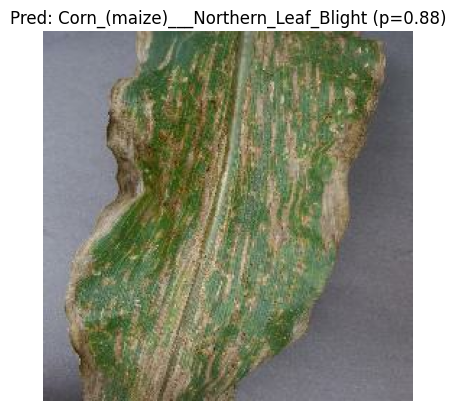

Probs: {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0.1215328574180603, 'Corn_(maize)___Common_rust_': 0.00012794890790246427, 'Corn_(maize)___healthy': 1.767093999660574e-05, 'Corn_(maize)___Northern_Leaf_Blight': 0.8783215284347534}


('Corn_(maize)___Northern_Leaf_Blight',
 array([1.2153286e-01, 1.2794891e-04, 1.7670940e-05, 8.7832153e-01],
       dtype=float32))

In [ ]:

dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot"
specific_img = "00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp 4655.JPG"
early_blight = os.path.join(dataset_path, vegetable_leaf, specific_img)
# Ejecuta
predict_external_image(early_blight)

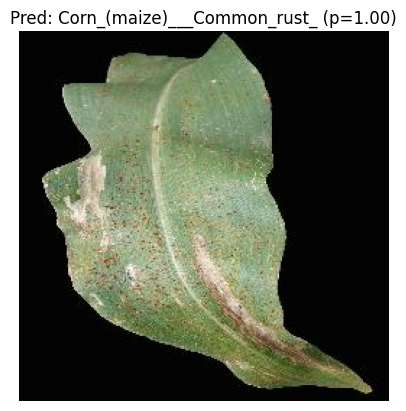

Probs: {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 2.6803040782397147e-06, 'Corn_(maize)___Common_rust_': 0.9999971389770508, 'Corn_(maize)___healthy': 1.9731347222773366e-08, 'Corn_(maize)___Northern_Leaf_Blight': 9.820931978765657e-08}


('Corn_(maize)___Common_rust_',
 array([2.6803041e-06, 9.9999714e-01, 1.9731347e-08, 9.8209320e-08],
       dtype=float32))

In [ ]:
dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Corn_(maize)___Common_rust_"
specific_img = "RS_Rust 1563.JPG"

late_blight = os.path.join(dataset_path, vegetable_leaf, specific_img)

predict_external_image(late_blight)

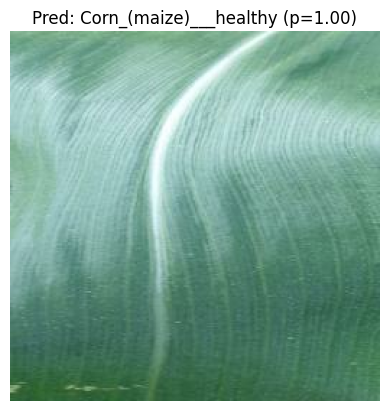

Probs: {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 2.861862640202162e-07, 'Corn_(maize)___Common_rust_': 3.8916321500437334e-05, 'Corn_(maize)___healthy': 0.9999606609344482, 'Corn_(maize)___Northern_Leaf_Blight': 1.8102535648267803e-07}


('Corn_(maize)___healthy',
 array([2.8618626e-07, 3.8916322e-05, 9.9996066e-01, 1.8102536e-07],
       dtype=float32))

In [ ]:

dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Corn_(maize)___healthy"
specific_img = "0a1a49a8-3a95-415a-b115-4d6d136b980b___R.S_HL 8216 copy.JPG"

late_blight_2 = os.path.join(dataset_path, vegetable_leaf, specific_img)

predict_external_image(late_blight_2)

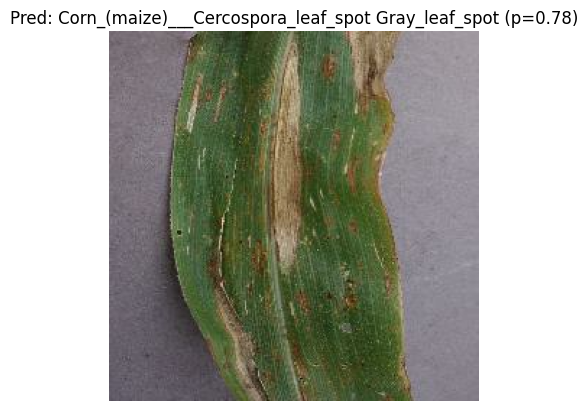

Probs: {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0.7819204926490784, 'Corn_(maize)___Common_rust_': 9.933913133863825e-06, 'Corn_(maize)___healthy': 4.957132478011772e-05, 'Corn_(maize)___Northern_Leaf_Blight': 0.2180200219154358}


('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 array([7.8192049e-01, 9.9339131e-06, 4.9571325e-05, 2.1802002e-01],
       dtype=float32))

In [ ]:

dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Corn_(maize)___Northern_Leaf_Blight"
specific_img = "00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG"

Healthy = os.path.join(dataset_path, vegetable_leaf, specific_img)

predict_external_image(Healthy)